
# Assignment 1 — Logistic Regression (Binary, NumPy-only) **No Data Leak**
Yêu cầu:
- **NumPy-only** để xây mô hình Logistic Regression (binary: *graduate* vs *non-graduate*).
- Huấn luyện bằng **Gradient Descent** trên bộ dữ liệu UCI *Predict students’ dropout and academic success* (ID=697).
- **Gộp nhãn**: `graduate` → 1; `dropout` hoặc `enrolled` → 0.
- **Đánh giá** mô hình (accuracy, precision, recall, F1, confusion matrix).
- **Trực quan hóa** hàm mất mát (loss) theo epoch.
- **Tránh mọi hình thức data leakage**: split **trước**, mọi biến đổi/loại thuộc tính/chuẩn hóa đều **fit trên train** rồi áp dụng cho test.
- **Bổ sung**: In thông tin từng biến; vẽ **ma trận tương quan** (trên **train**); loại bỏ thuộc tính có tương quan cao (|corr| ≥ 0.9) **dựa trên train**.


In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# cấu hình
RANDOM_SEED = 42
TRAIN_RATIO = 0.8
HIGH_CORR_THRESHOLD = 0.90  # loại bỏ thuộc tính có |corr| >= ngưỡng
rng = np.random.default_rng(RANDOM_SEED)

def safe_show():
    try:
        plt.show()
    except Exception as e:
        print("Plot display error:", e)


In [10]:

# 1) Tải dữ liệu
from ucimlrepo import fetch_ucirepo

ds = fetch_ucirepo(id=697)
X = ds.data.features.copy()
y = ds.data.targets.copy()

print("Loaded UCI dataset 697")
print("X shape:", X.shape, "| y shape:", y.shape)
display(X.head(3))
display(y.head(3))

# Cột nhãn
target_col = 'Target' if 'Target' in y.columns else y.columns[0]
y_str = y[target_col].astype(str)


Loaded UCI dataset 697
X shape: (4424, 36) | y shape: (4424, 1)


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74


,Target
0,Dropout
1,Graduate
2,Dropout


## Thông tin từng biến thành phần trong bộ dữ liệu

In [11]:

df_full = pd.concat([X.copy(), y_str.rename('Target')], axis=1)
for col_name in df_full.columns:
    print("Title:", col_name)
    print("Total NaN:", df_full[col_name].isna().sum())
    print("Total null:", df_full[col_name].isnull().sum())
    print("Data type:", df_full[col_name].dtype)
    print("*"*10)


Title: Marital Status
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Application mode
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Application order
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Course
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Daytime/evening attendance
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Previous qualification
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Previous qualification (grade)
Total NaN: 0
Total null: 0
Data type: float64
**********
Title: Nacionality
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Mother's qualification
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Father's qualification
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Mother's occupation
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Father's occupation
Total NaN: 0
Total null: 0
Data type: int64
**********
Title: Admission g

## Gộp nhãn & Chia train/test (stratified, trước mọi biến đổi)

In [12]:

# Gộp nhãn: graduate=1, (dropout|enrolled)=0
y_bin = y_str.str.strip().str.lower().map(lambda t: 1 if t.startswith('gradu') else 0).values.astype(int)

# Stratified split bằng NumPy
idx_all = np.arange(len(y_bin))
tr_idx_list, te_idx_list = [], []
for label in np.unique(y_bin):
    idx_c = idx_all[y_bin == label]
    rng.shuffle(idx_c)
    split = int(TRAIN_RATIO * len(idx_c))
    tr_idx_list.append(idx_c[:split])
    te_idx_list.append(idx_c[split:])
tr_idx = np.concatenate(tr_idx_list); te_idx = np.concatenate(te_idx_list)
rng.shuffle(tr_idx); rng.shuffle(te_idx)

X_tr_df = X.iloc[tr_idx].copy()
X_te_df = X.iloc[te_idx].copy()
y_tr = y_bin[tr_idx]
y_te = y_bin[te_idx]

print("Train size:", len(y_tr), "| Test size:", len(y_te))
print("Class dist (train):", {k:int((y_tr==k).sum()) for k in np.unique(y_tr)})
print("Class dist (test):", {k:int((y_te==k).sum()) for k in np.unique(y_te)})


Train size: 3539 | Test size: 885
Class dist (train): {0: 1772, 1: 1767}
Class dist (test): {0: 443, 1: 442}


## One-hot các cột phân loại (fit trên **train**, áp dụng cho **test**)

In [13]:

# Xác định cột phân loại từ TRAIN
cat_cols = X_tr_df.select_dtypes(exclude=[np.number]).columns.tolist()

# One-hot train
X_tr_oh = pd.get_dummies(X_tr_df, columns=cat_cols, drop_first=True)

# One-hot test rồi reindex theo train
X_te_oh = pd.get_dummies(X_te_df, columns=cat_cols, drop_first=True)
X_te_oh = X_te_oh.reindex(columns=X_tr_oh.columns, fill_value=0)

print("After one-hot: train shape =", X_tr_oh.shape, "| test shape =", X_te_oh.shape)


After one-hot: train shape = (3539, 36) | test shape = (885, 36)


## Ma trận tương quan (tính **trên TRAIN**) cho các thuộc tính định lượng

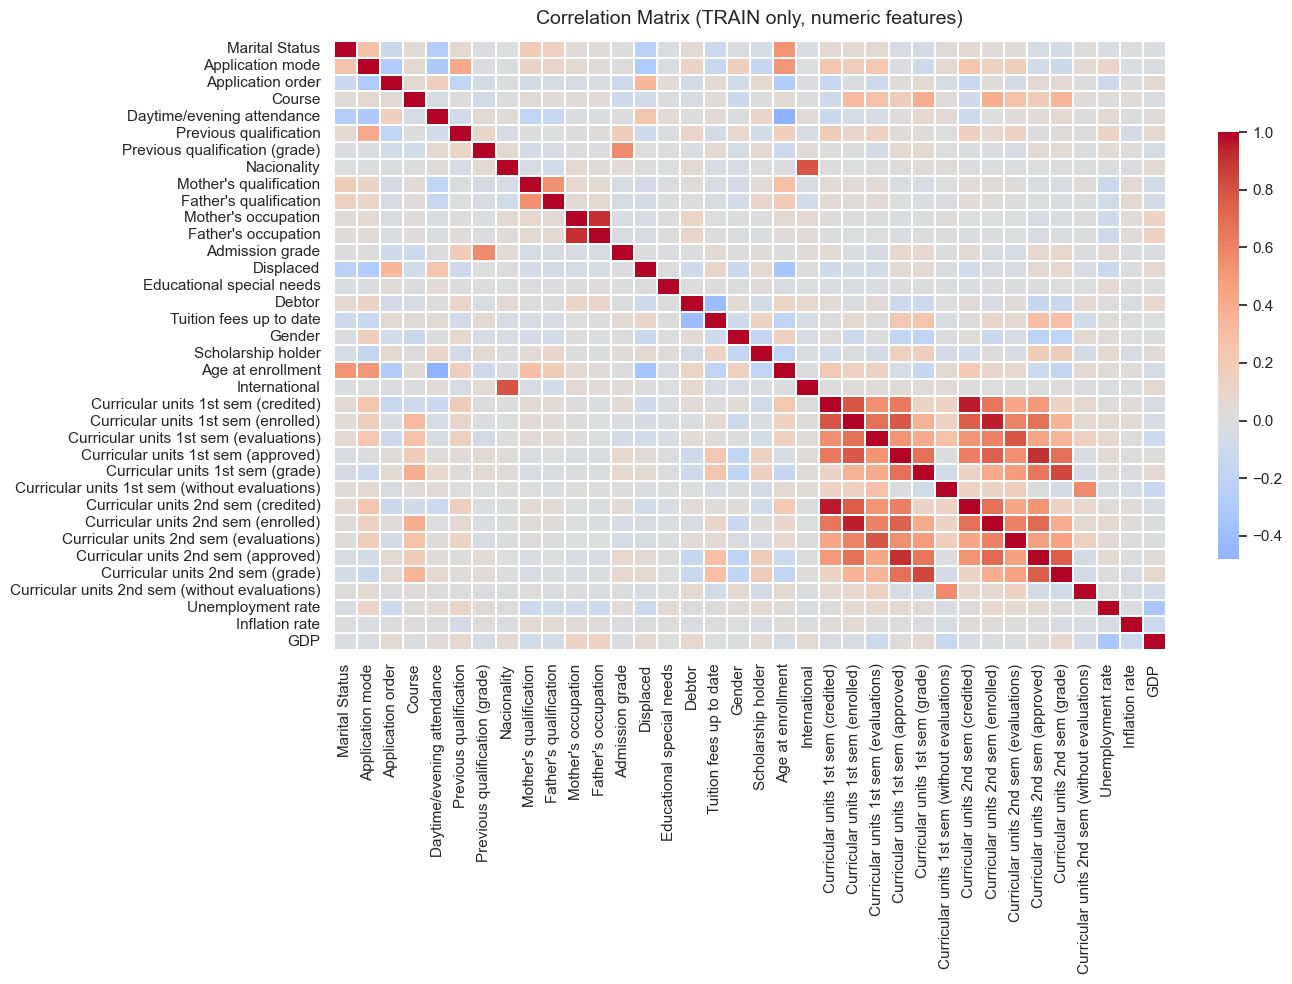

In [14]:

# Chỉ lấy cột số (sau one-hot, tất cả là số), nhưng để minh họa, ta tính corr trên TRAIN
corr = X_tr_oh.corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.set_theme(style='white')
sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    cbar_kws={'shrink': 0.7},
    square=False,
    linewidths=0.2
)
plt.title("Correlation Matrix (TRAIN only, numeric features)", fontsize=14, pad=12)
plt.tight_layout()
safe_show()


## Loại thuộc tính có tương quan cao (|corr| ≥ 0.90) **dựa trên TRAIN**, rồi áp dụng cho TEST

In [15]:

to_drop = set()
corr_mat = corr.abs()
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))

for col in upper.columns:
    high_corr_partners = [row for row, val in upper[col].items() if (not pd.isna(val)) and (val >= HIGH_CORR_THRESHOLD)]
    if len(high_corr_partners) > 0:
        # Chiến lược đơn giản: drop cột 'col' (giữ các cột còn lại)
        to_drop.add(col)

to_drop = sorted(list(to_drop))
print("Số cột bị loại do tương quan cao:", len(to_drop))
print("Danh sách (preview 30):", to_drop[:30])

X_tr_sel = X_tr_oh.drop(columns=to_drop, errors='ignore')
X_te_sel = X_te_oh.drop(columns=to_drop, errors='ignore')

print("Shapes after drop-high-corr: train =", X_tr_sel.shape, "| test =", X_te_sel.shape)


Số cột bị loại do tương quan cao: 4
Danh sách (preview 30): ['Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', "Father's occupation"]
Shapes after drop-high-corr: train = (3539, 32) | test = (885, 32)


## Chuẩn hoá theo thống kê **train**, rồi áp dụng cho **test** (không leak)

In [16]:
# Chuẩn hoá theo train bằng NumPy (KHÔNG LEAK)
# 1) convert DataFrame -> NumPy
Xtr_np = X_tr_sel.to_numpy(dtype=float)
Xte_np = X_te_sel.to_numpy(dtype=float)

# 2) tính mean/std trên TRAIN, dạng (1, d)
mu  = Xtr_np.mean(axis=0, keepdims=True)
std = Xtr_np.std(axis=0,  keepdims=True) + 1e-8

# 3) transform: dùng thống kê của TRAIN cho cả train/test
Xtr = (Xtr_np - mu) / std
Xte = (Xte_np - mu) / std

# 4) thêm cột bias = 1
Xtr = np.hstack([np.ones((Xtr.shape[0], 1)), Xtr])
Xte = np.hstack([np.ones((Xte.shape[0], 1)), Xte])

print("Final matrices:", Xtr.shape, Xte.shape)


Final matrices: (3539, 33) (885, 33)


## Huấn luyện Logistic Regression (NumPy-only, Gradient Descent)

In [17]:

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def bce_loss_logits(z, y):
    # BCE ổn định số học
    return np.mean(np.maximum(z, 0) - y*z + np.log1p(np.exp(-np.abs(z))))

def predict_proba(W, X):
    return sigmoid(X @ W)

def predict_label(W, X, thr=0.5):
    return (predict_proba(W, X) >= thr).astype(int)

def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

# Khởi tạo
n, d = Xtr.shape
W = np.zeros((d,), dtype=float)
LR = 0.1
EPOCHS = 500
losses = []

# Train loop
for ep in range(EPOCHS):
    z = Xtr @ W
    p = sigmoid(z)
    loss = bce_loss_logits(z, y_tr)
    losses.append(loss)

    grad = (Xtr.T @ (p - y_tr)) / n
    W -= LR * grad

    if (ep + 1) % 50 == 0:
        print(f"Epoch {ep+1}/{EPOCHS} | loss={loss:.6f}")


Epoch 50/500 | loss=0.449647
Epoch 100/500 | loss=0.419334
Epoch 150/500 | loss=0.405604
Epoch 200/500 | loss=0.397594
Epoch 250/500 | loss=0.392330
Epoch 300/500 | loss=0.388606
Epoch 350/500 | loss=0.385830
Epoch 400/500 | loss=0.383677
Epoch 450/500 | loss=0.381956
Epoch 500/500 | loss=0.380546


## Đánh giá mô hình

In [18]:

# Dự đoán
yhat_tr = predict_label(W, Xtr)
yhat_te = predict_label(W, Xte)

def pr_re_f1(y_true, y_pred):
    tp = np.sum((y_true==1)&(y_pred==1))
    tn = np.sum((y_true==0)&(y_pred==0))
    fp = np.sum((y_true==0)&(y_pred==1))
    fn = np.sum((y_true==1)&(y_pred==0))
    prec = tp/(tp+fp+1e-12)
    rec  = tp/(tp+fn+1e-12)
    f1   = 2*prec*rec/(prec+rec+1e-12)
    cm = np.array([[tn, fp],[fn, tp]], dtype=int)
    return prec, rec, f1, cm

prec_tr, rec_tr, f1_tr, cm_tr = pr_re_f1(y_tr, yhat_tr)
prec_te, rec_te, f1_te, cm_te = pr_re_f1(y_te, yhat_te)

print("Train: acc={:.4f}, P={:.4f}, R={:.4f}, F1={:.4f}".format((y_tr==yhat_tr).mean(), prec_tr, rec_tr, f1_tr))
print("Test : acc={:.4f}, P={:.4f}, R={:.4f}, F1={:.4f}".format((y_te==yhat_te).mean(), prec_te, rec_te, f1_te))
print("Confusion Matrix (Test):\n", cm_te)


Train: acc=0.8302, P=0.8040, R=0.8727, F1=0.8369
Test : acc=0.8249, P=0.8126, R=0.8439, F1=0.8280
Confusion Matrix (Test):
 [[357  86]
 [ 69 373]]


## Đồ thị hàm mất mát (Loss) theo epoch

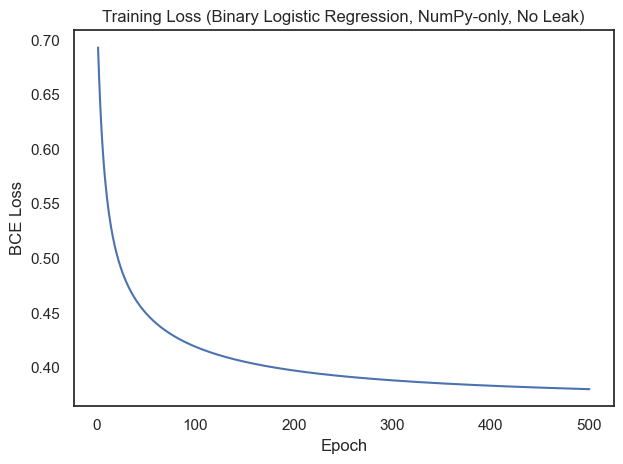

In [19]:

plt.figure()
plt.plot(range(1, len(losses)+1), losses)
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Training Loss (Binary Logistic Regression, NumPy-only, No Leak)")
plt.tight_layout()
safe_show()
